In [199]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from pywaffle import Waffle
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import HTML, display
import tabulate
from sklearn.feature_selection import RFECV, RFE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA

In [179]:
# data read in
path = "C:/Users/zpap/PycharmProjects/ELTE/Mathematical_modeling_practise/data/healthcare-dataset-stroke-data.csv"
dataset = pd.read_csv(path, header=0)

dataset.head()

dataset.info()

dataset.dtypes

dataset = dataset.astype({"id": "object",
                          "gender": "category",
                          "age": "int32",
                          "hypertension": "int32",
                          "heart_disease": "int32",
                          "ever_married": "category",
                          "work_type": "category",
                          "Residence_type": "category",
                          "avg_glucose_level": "float64",
                          "bmi": "float64",
                          "smoking_status": "category",
                          "stroke": "int32"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Here we can see, what kind of datatypes our dataset has**
 

In [180]:
# some data correction
dataset = dataset.drop("id", axis=1)

**Dropping column "id", since there is no need for eda or modeling**


In [181]:
# duplications
print(np.shape(dataset[dataset.duplicated(keep="first")].index))

(0,)


**From this zero, it can be concluded, that there is no duplicated row in the dataset**

**Now missing values are being counted**

In [182]:
# missing values
total_nulls = dataset.isnull().sum()
total_observations = dataset.shape[0]
null_percentages = total_nulls[total_nulls > 0] / total_observations * 100
print(pd.concat([total_nulls, null_percentages], axis=1, keys=["Total", "Percentage"]).fillna(0).sort_values(by="Total",
                                                                                                             ascending=False))

                   Total  Percentage
bmi                  201    3.933464
gender                 0    0.000000
age                    0    0.000000
hypertension           0    0.000000
heart_disease          0    0.000000
ever_married           0    0.000000
work_type              0    0.000000
Residence_type         0    0.000000
avg_glucose_level      0    0.000000
smoking_status         0    0.000000
stroke                 0    0.000000


**The dataset is pretty much filled, only bmi column has suffered from lost recording, therefore imputing essential.<br>**
**First lets check, that can we model this data at all with a basic technique.<br>**
<br>
**The reason for this step is, that we dont know, how many observations our data has, and since it is a classification problem, we dont want our prediction to only have zeros in it.**

In [183]:
# Imputing missing value
def create_dummies(data, variable):
    result = pd.concat([data.drop(variable, axis=1), pd.get_dummies(data[variable], prefix=variable).iloc[:, :-1]],
                       axis=1)
    return result


data_cleaned = create_dummies(dataset.copy(), "gender")
data_cleaned = create_dummies(data_cleaned, "work_type")
data_cleaned = create_dummies(data_cleaned, "Residence_type")
data_cleaned = create_dummies(data_cleaned, "smoking_status")
data_cleaned = create_dummies(data_cleaned, "ever_married")



# before we impute, set the imbalance dataset
data_cleaned_modeling = data_cleaned.copy().dropna(axis=1)

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]
counter = Counter(y)
print(counter)
print(f"Observation in dataset {round(counter[1] / sum(counter.values()) * 100, 2)}%")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

scaling = StandardScaler()

model = LogisticRegression(penalty='l2',
                           dual=False,
                           tol=0.0001,
                           C=1.0,
                           fit_intercept=True,
                           intercept_scaling=1,
                           class_weight=None,
                           random_state=1234,
                           solver='lbfgs',
                           max_iter=1000,
                           multi_class="auto",
                           verbose=0,
                           warm_start=False,
                           n_jobs=None,
                           l1_ratio=None)

std_lr = Pipeline(steps=[('scale', scaling), ('model', model)])
std_lr.fit(X_train, y_train)
pred = std_lr.predict(X_test)
print(metrics.accuracy_score(pred, y_test))  # 94.84%
pred.sum()  # null model!

# we must use smote technique

Counter({0: 4861, 1: 249})
Observation in dataset 4.87%
0.9484670580560991


0

**Category variables must be converted into dummy variables, and if a dummy variable is used, than n-1 column is just enough, where n is the number of different categories in a column.<br><br>**
**From the results we can see, that around 4.87% observations we have, which shows that this dataset is highly imbalanced. After this information, it was expected, that our fitted logistic regression model could predict only zeros.<br><br>**
**The reason, why this information is crucial in this early stage of the analysis, is that i am going try out different techniques for imputing, and it will be backtested with a K-fold cross validation.<br>**
**Following techniques are going to be tried out:**
* Delete the column bmi.
* Delete the rows of bmi having NAs.
* Imputing with mean of bmi.
* Imputing with medain of bmi.
* Imputing with mostr frequent value of bmi.
* Imputing Linear regression model, predicting the NAs.
* Imputing KNN model, predicting the NAs.

Observation in dataset 33.33%


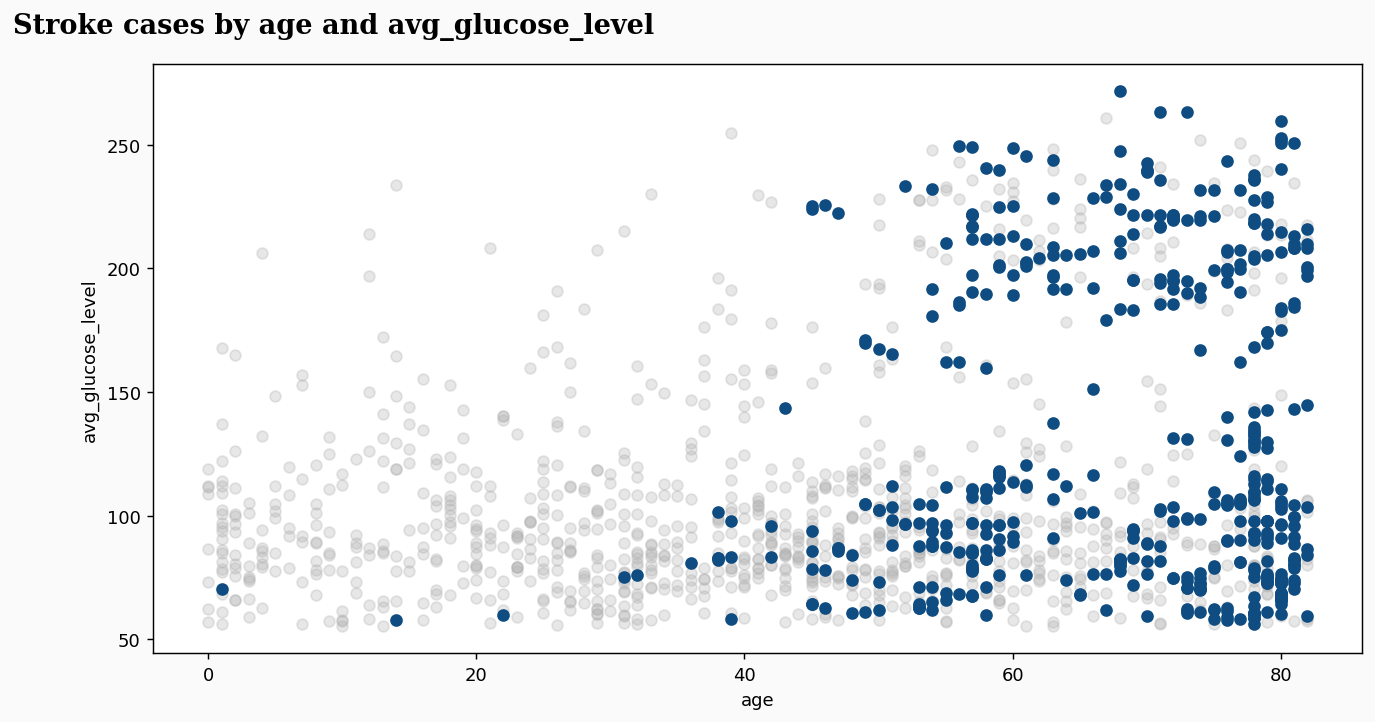

In [184]:
# 1. delete col
x_labels = list()
mean_accuracy_cv = list()
std_accuracy_cv = list()


def imputing_techniques_smote_cross_val(X, y, plot):
    over = SMOTE(sampling_strategy=0.1, random_state=1234)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=1234)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)

    if plot:
        # summarize the new class distribution
        counter = Counter(y)
        print(f"Observation in dataset {round(counter[1] / sum(counter.values()) * 100, 2)}%")
        # scatter plot of examples by age vs avg_glucose_level
        fig = plt.figure(figsize=(12, 6), dpi=130, facecolor="#fafafa")
        ax = plt.subplot(111)
        colors = ["#B1B1B1", "#0f4c81"]
        alpha = [0.3, 1]
        for label, _ in counter.items():
            row_ix = np.where(y == label)[0]
            ax.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 3], label=str(label), c=colors[label], alpha=alpha[label])

        ax.set_ylabel('avg_glucose_level')
        ax.set_xlabel("age")

        fig.text(0.035, 0.92, f'Stroke cases by age and avg_glucose_level', fontfamily='serif', fontsize=15,
                 fontweight='bold')
        plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    pipe = Pipeline(steps=[("scale", scaling), ('model', model)])
    impute_scores = 1 - cross_val_score(
        pipe, X_train, y_train, scoring="recall_weighted", cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    )
    return impute_scores.mean(), impute_scores.std()


data_cleaned_modeling = data_cleaned.copy().dropna(axis=1)

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

result = imputing_techniques_smote_cross_val(X, y, plot=True)
x_labels.append("Delete column")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

**This imbalanced dataset has been corrected with SMOTE (Synthetic Minority Over-sampling Technique) by first oversampling the minority class, then undersampling the majority class.<br> In more detail, a random example has been selected from the minority class and then KNN  finds its neighbours, where a randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. This approach created a more balanced ditribution. With this technique, this dataset can be modeled.**

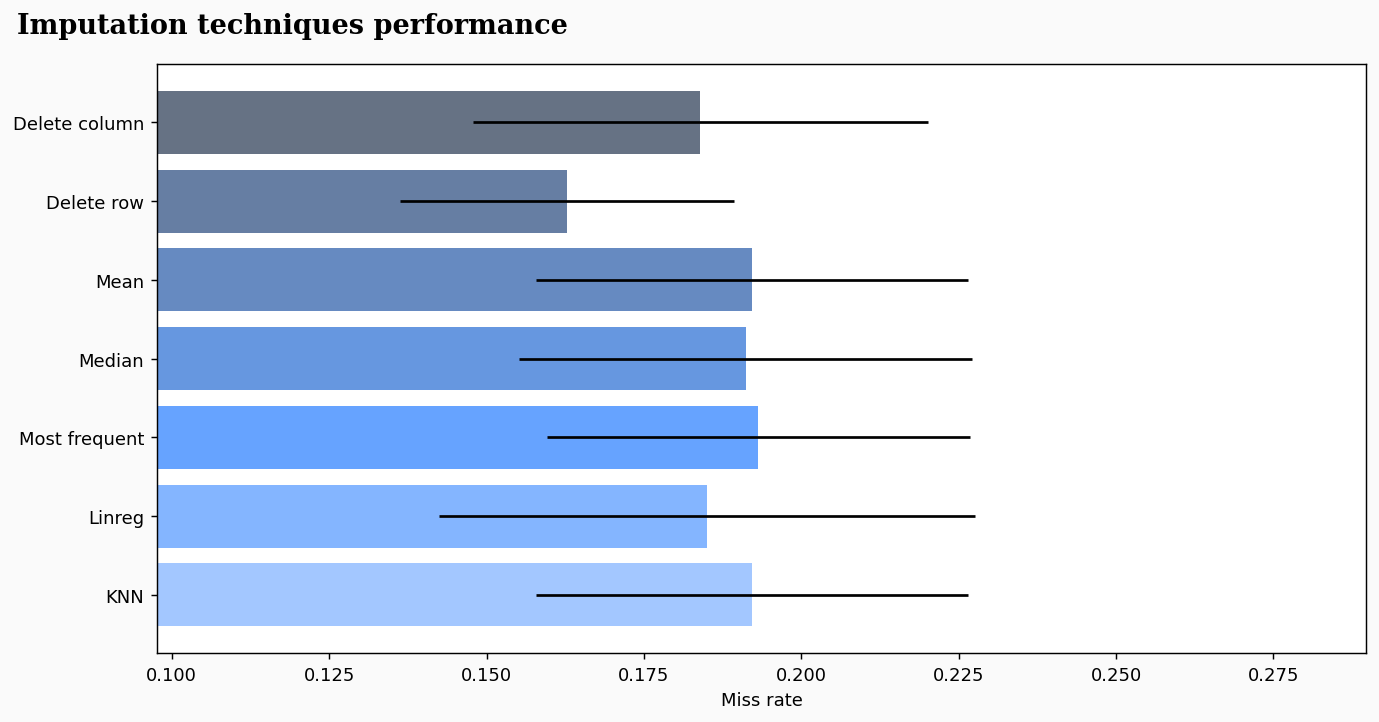

In [185]:
# 2. deleting rows filled with NA
data_cleaned_modeling = data_cleaned.copy().dropna(axis=0)
data_cleaned_modeling.isnull().sum()

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)
x_labels.append("Delete row")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# 3. mean
data_cleaned_modeling = data_cleaned.copy()

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X["bmi"] = imp_mean.fit_transform(X["bmi"].to_numpy().reshape(-1, 1))

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)
x_labels.append("Mean")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# 3. median
data_cleaned_modeling = data_cleaned.copy()

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X["bmi"] = imp_mean.fit_transform(X["bmi"].to_numpy().reshape(-1, 1))

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)
x_labels.append("Median")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# 4. most_frequent
data_cleaned_modeling = data_cleaned.copy()

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X["bmi"] = imp_mean.fit_transform(X["bmi"].to_numpy().reshape(-1, 1))

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)
x_labels.append("Most frequent")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# 5. lets do some modeling missing values, with regression
lr = LinearRegression()

data_cleaned_modeling = data_cleaned.copy()

test_bmi = data_cleaned_modeling[data_cleaned['bmi'].isnull() == True]  # all na rows of bmi
train_bmi = data_cleaned_modeling[data_cleaned['bmi'].isnull() == False]

y = train_bmi['bmi']
train_bmi = train_bmi.drop("bmi", axis=1)
std_lr = Pipeline(steps=[("scale", scaling), ('model', lr)])
std_lr.fit(train_bmi, y)
test_bmi = test_bmi.drop("bmi", axis=1)
pred = std_lr.predict(test_bmi)
test_bmi['bmi'] = pred
train_bmi['bmi'] = y
data_cleaned_modeling = pd.concat([train_bmi, test_bmi], axis=0)

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)
x_labels.append("Linreg")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# 6. knn
data_cleaned_modeling = data_cleaned.copy()

X = data_cleaned_modeling.drop("stroke", axis=1)
y = data_cleaned_modeling["stroke"]

knn = KNNImputer(n_neighbors=3)
X["bmi"] = knn.fit_transform(X["bmi"].to_numpy().reshape(-1, 1))

result = imputing_techniques_smote_cross_val(X=X, y=y, plot=False)

x_labels.append("KNN")
mean_accuracy_cv.append(result[0])
std_accuracy_cv.append(result[1])

# aggregate results
n_bars = len(mean_accuracy_cv)
xval = np.arange(n_bars)

colors = ["#001433", "#002966", "#003d99", "#0052cc", "#0066ff", "#3385ff", "#66a3ff"]

# plot diabetes results
fig = plt.figure(figsize=(12, 6), dpi=130, facecolor="#fafafa")
ax = plt.subplot(111)
for j in xval:
    ax.barh(
        j,
        mean_accuracy_cv[j],
        xerr=std_accuracy_cv[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax.set_xlim(left=np.min(mean_accuracy_cv) * 0.6, right=np.max(mean_accuracy_cv) * 1.5)
ax.set_yticks(xval)
ax.set_xlabel("Miss rate")
ax.invert_yaxis()
ax.set_yticklabels(x_labels)
fig.text(0.035, 0.92, "Imputation techniques performance", fontfamily='serif', fontsize=15, fontweight='bold')

plt.show()

# cant choose delete rows, because 40 stroke cases would have been dropped, linreg high var as expected,
# median convincing

dataset.loc[dataset["bmi"].isnull(), "stroke"].sum()

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
dataset["bmi"] = imp_mean.fit_transform(dataset["bmi"].to_numpy().reshape(-1, 1))

**Different imputing techniques have been tried out. After one of them has been applied on column bmi, then 10 fold cross validation with logistic regression has been used to measure its future performance.<br> Cross validation metric is the false negative rate or miss rate, calculated with 1 - recall, since the object is to have a method, where actual positive cases missclassified as no stroke by the model is minimized.**<br><br>
**Result of the techniques:**
* Deleting column, is never a good approach, reasonal information could have been lost.
* Deleting the row performed the best, with lowest miss rate and std, but it also looses observation stroke cases, which is crucial to include them. 
* Mean, medain, and most frequent did performed well, all of them being close to each other.
* Linear regression has performed really well, but as it is seen on the plot, it has relatively high std compared to the other techniques, which makes it unstable.
* KNN also performed well.

**Many approaches can be chosen here, I select the median, as it is provided a robust result.**

**Target variable analysis**

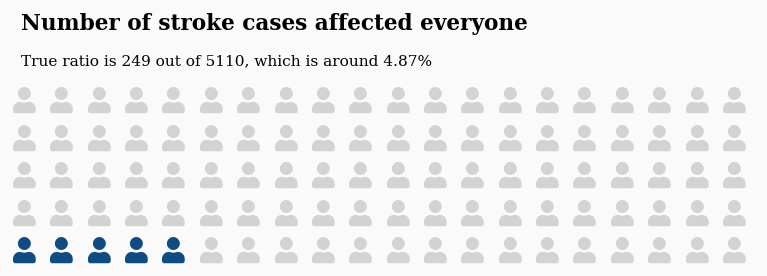

In [9]:
# target variable analysing
dataset.isnull().sum()
dataset.stroke.sum() / np.shape(dataset)[0] # 0.048, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[5, 95],
    colors=['#0f4c81', "lightgray"],
    icons='user',
    icon_size='x-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases affected everyone', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 249 out of 5110, which is around 4.87%', fontfamily='serif', fontsize=8.5)

plt.show()

**Around 4.87% stroke cases included in the dataset.**

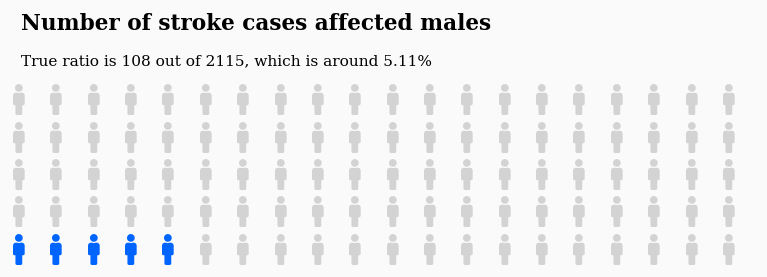

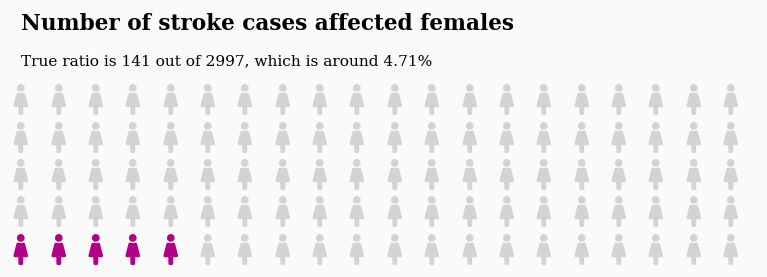

In [10]:
# lets analyse the number of strokes by gender
data_male = dataset[dataset.gender == "Male"].reset_index()
data_male.stroke.sum() / np.shape(data_male)[0] # 0.051, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[5, 95],
    colors=['#0064FF', "lightgray"],
    icons='male',
    icon_size='xx-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases affected males', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 108 out of 2115, which is around 5.11%', fontfamily='serif', fontsize=8.5)

plt.show()



data_female = dataset[dataset.gender == "Female"].reset_index()
data_female.stroke.sum() / np.shape(data_female)[0] # 0.047, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[5, 95],
    colors=['#b30086', "lightgray"],
    icons='female',
    icon_size='xx-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases affected females', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 141 out of 2997, which is around 4.71%', fontfamily='serif', fontsize=8.5)

plt.show()

**Stroke cases does not occure more often if the dataset is splitted by gender. Stroke effects both of them almost equally.**

**Age distribution, and those people, who suffered stroke.**

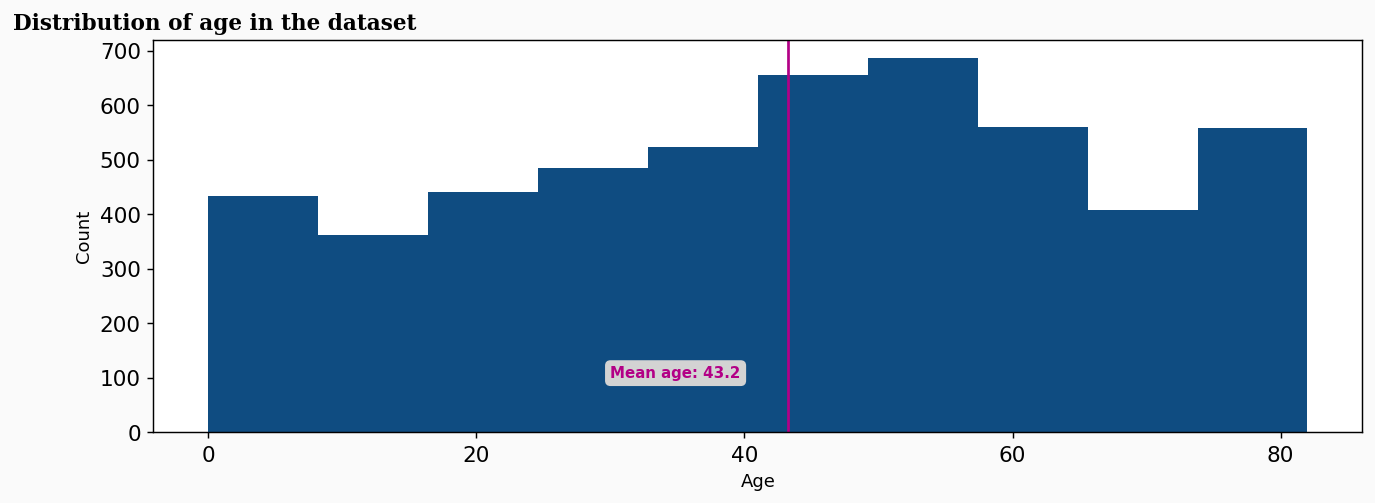

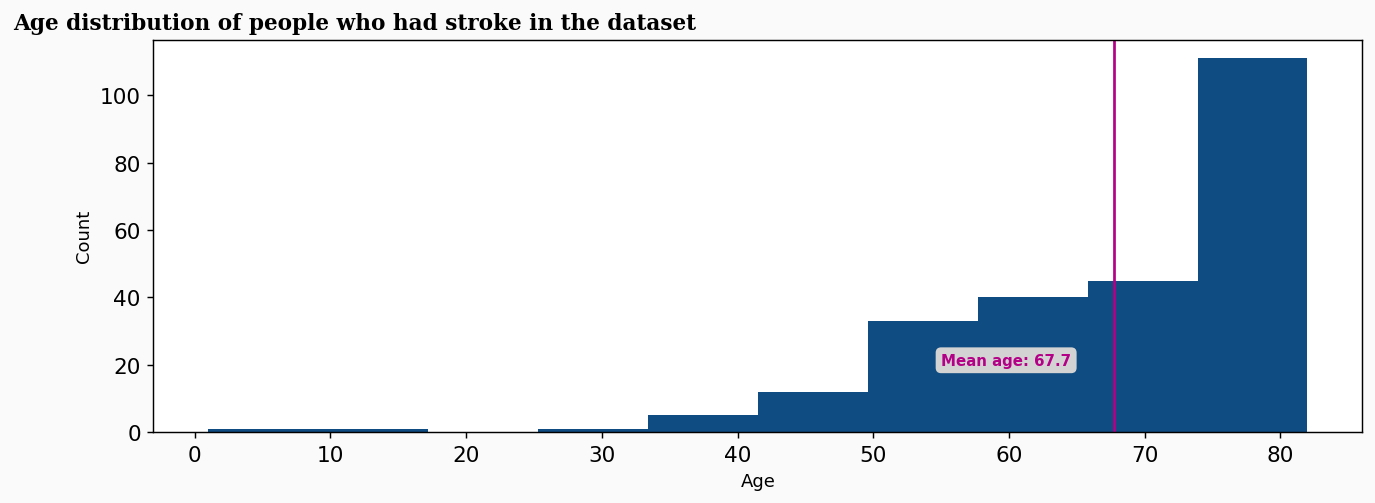

In [85]:
# average value, when people got stroke
fig = plt.figure(figsize=(12, 4),dpi=130, facecolor="#fafafa")
ax = plt.subplot(111)
ax.hist(x=dataset["age"], alpha=1, color="#0f4c81")
ax.axvline(dataset["age"].mean(), color="#b30086")
ax.text(30, 100, "Mean age: " + str(round(dataset["age"].mean(), 1)), color="#b30086", weight="heavy", size="smaller", bbox=dict(boxstyle="round", color="lightgrey"))
ax.set_xlabel("Age", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
fig.text(0.035,0.90,'Distribution of age in the dataset', fontfamily='serif', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



fig = plt.figure(figsize=(12, 4),dpi=130, facecolor="#fafafa")
ax = plt.subplot(111)
ax.hist(x=dataset[dataset["stroke"]==1]["age"], alpha=1, color="#0f4c81")
ax.axvline(dataset[dataset["stroke"]==1]["age"].mean(), color="#b30086")
ax.text(55, 20, "Mean age: " + str(round(dataset[dataset["stroke"]==1]["age"].mean(), 1)), color="#b30086", weight="heavy", size="smaller", bbox=dict(boxstyle="round", color="lightgrey"))
ax.set_xlabel("Age", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
fig.text(0.035,0.90,'Age distribution of people who had stroke in the dataset', fontfamily='serif', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

**It can be seen, that people in the dataset are close to the uniform distribution by age.**<br>
<br>
**Those people with stroke record, are affected after the age of around 40. The average age of having a stroke is 68.**

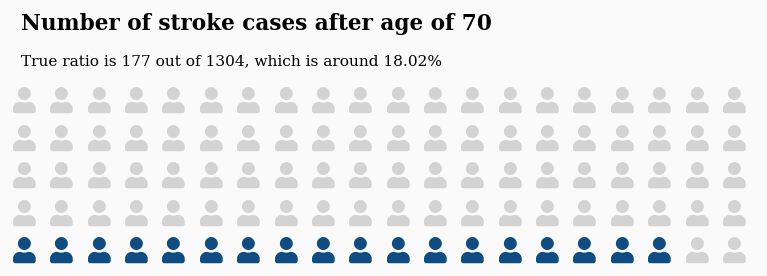

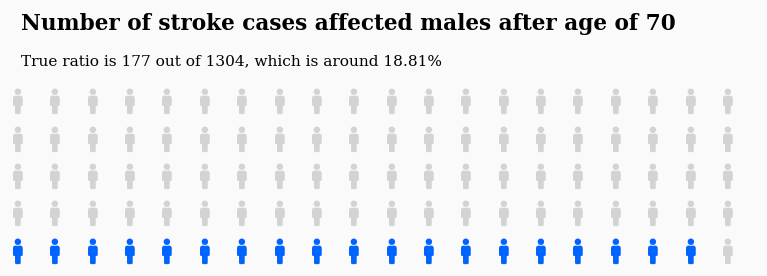

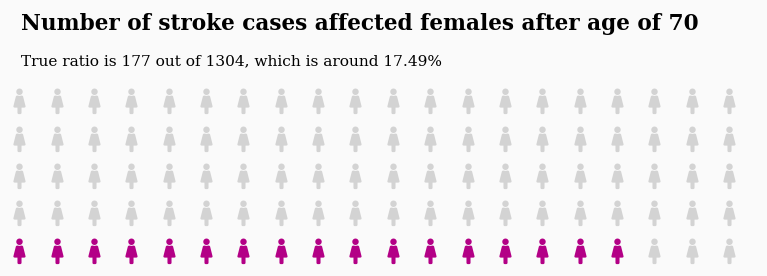

In [81]:
# older than 70
dataset[dataset["age"] > 70].stroke.sum() / np.shape(dataset[dataset["age"] > 70])[0] # 0.1802, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[18, 82],
    colors=['#0f4c81', "lightgray"],
    icons='user',
    icon_size='x-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases after age of 70', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 177 out of 1304, which is around 18.02%', fontfamily='serif', fontsize=8.5)

plt.show()

dataset[(dataset["age"] > 70) & (dataset["gender"] == "Male")].stroke.sum() / np.shape(dataset[(dataset["age"] > 70) & (dataset["gender"] == "Male")])[0] # 0.1881, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[19, 81],
    colors=['#0064FF', "lightgray"],
    icons='male',
    icon_size='x-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases affected males after age of 70', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 177 out of 1304, which is around 18.81%', fontfamily='serif', fontsize=8.5)

plt.show()

dataset[(dataset["age"] > 70) & (dataset["gender"] == "Female")].stroke.sum() / np.shape(dataset[(dataset["age"] > 70) & (dataset["gender"] == "Female")])[0] # 0.1881, which is

fig = plt.figure(figsize=(6, 3),dpi=130,facecolor="#fafafa",
    FigureClass=Waffle,
    rows=5,
    values=[17, 83],
    colors=['#b30086', "lightgray"],
    icons='female',
    icon_size='x-large',
    font_size=20,vertical=True,
)

fig.text(0.035,0.86,'Number of stroke cases affected females after age of 70', fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.035,0.77,'True ratio is 177 out of 1304, which is around 17.49%', fontfamily='serif', fontsize=8.5)

plt.show()

**Analyzin the distribution of age above 70 by gender. Observation are enriched to 18%**

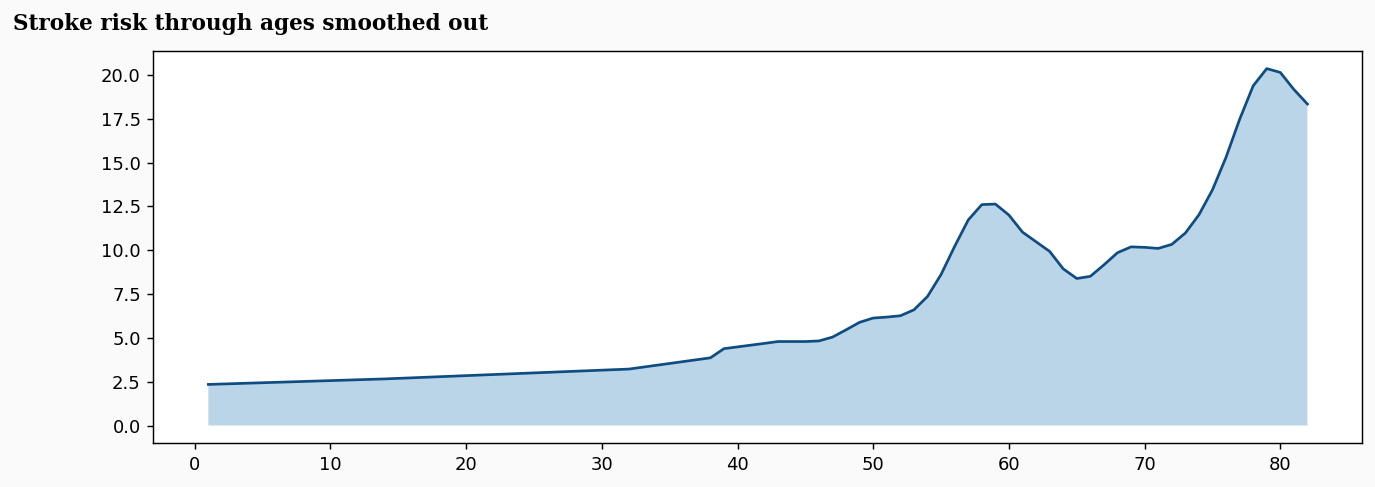

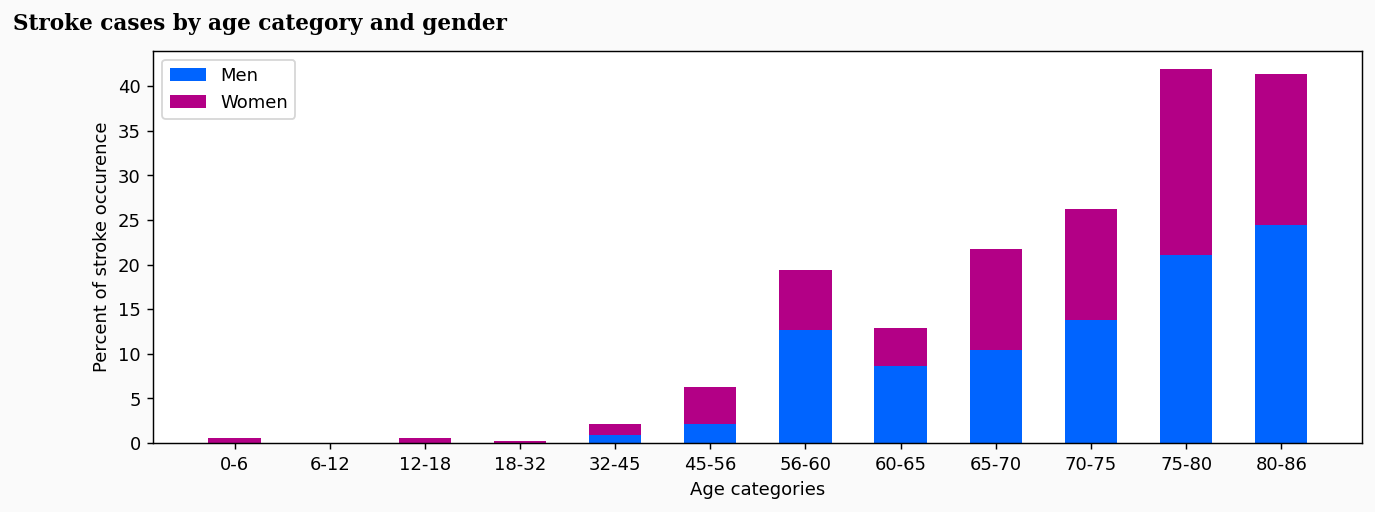

In [65]:
# lets check by age
dataset_stroke_by_age = dataset[["age", "gender", "stroke"]].sort_values("age")

age_stroke = dataset_stroke_by_age[dataset_stroke_by_age["stroke"] == 1].groupby("age").agg({"stroke": np.sum}).reset_index()
all_age = dataset_stroke_by_age.groupby("age").count()

age_stroke["stroke"] /= round(0.01*all_age["stroke"],2)


age_stroke["smoothed"] = gaussian_filter1d(age_stroke["stroke"], sigma=2)

fig = plt.figure(figsize=(12, 4),dpi=130, facecolor="#fafafa")
ax = fig.add_subplot(111)
ax.plot(age_stroke["age"], age_stroke["smoothed"], c="#0f4c81")
fig.text(0.035,0.92,'Stroke risk through ages smoothed out', fontfamily='serif', fontsize=12, fontweight='bold')
ax.fill_between(age_stroke["age"], age_stroke["smoothed"],alpha=0.30)
plt.show()

dataset_stroke_by_age["age_cut"] = pd.cut(dataset_stroke_by_age["age"],
                                          bins=[-1, 6, 12, 18, 32, 45, 56, 60, 65, 70, 75, 80, 86],
                                          labels=["0-6", "6-12", "12-18", "18-32", "32-45",
                                                  "45-56", "56-60", "60-65","65-70", "70-75", "75-80", "80-86"])

male_stroke_by_age = dataset_stroke_by_age[dataset_stroke_by_age["gender"] == "Male"].groupby("age_cut").agg({"stroke": np.sum})
data_male["age_cut"] = pd.cut(data_male["age"],
                                          bins=[-1, 6, 12, 18, 32, 45, 56, 60, 65, 70, 75, 80, 86],
                                          labels=["0-6", "6-12", "12-18", "18-32", "32-45",
                                                  "45-56", "56-60", "60-65","65-70", "70-75", "75-80", "80-86"])

male_stroke_by_age["stroke"] = round(male_stroke_by_age["stroke"] / data_male.groupby('age_cut').count()["index"] * 100, 2)

female_stroke_by_age = dataset_stroke_by_age[dataset_stroke_by_age["gender"] == "Female"].groupby("age_cut").agg({"stroke": np.sum})
data_female["age_cut"] = pd.cut(data_female["age"],
                                          bins=[-1, 6, 12, 18, 32, 45, 56, 60, 65, 70, 75, 80, 86],
                                          labels=["0-6", "6-12", "12-18", "18-32", "32-45",
                                                  "45-56", "56-60", "60-65","65-70", "70-75", "75-80", "80-86"])

female_stroke_by_age["stroke"] = round(female_stroke_by_age["stroke"] / data_female.groupby('age_cut').count()["index"] * 100, 2)
ind = ["0-6", "6-12", "12-18", "18-32", "32-45",
       "45-56", "56-60", "60-65","65-70", "70-75", "75-80", "80-86"]

width = 0.55       # the width of the bars: can also be len(x) sequence
fig = plt.figure(figsize=(12, 4),dpi=130, facecolor="#fafafa")

p1 = plt.bar(ind, male_stroke_by_age["stroke"], width,color="#0064FF")
p2 = plt.bar(ind, female_stroke_by_age["stroke"], width, color="#b30086",   bottom=male_stroke_by_age["stroke"])

plt.ylabel('Percent of stroke occurence')
plt.xlabel('Age categories')

fig.text(0.035,0.92,'Stroke cases by age category and gender', fontfamily='serif', fontsize=12, fontweight='bold')

plt.xticks(ind)

plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()
# clearly age has an effect!

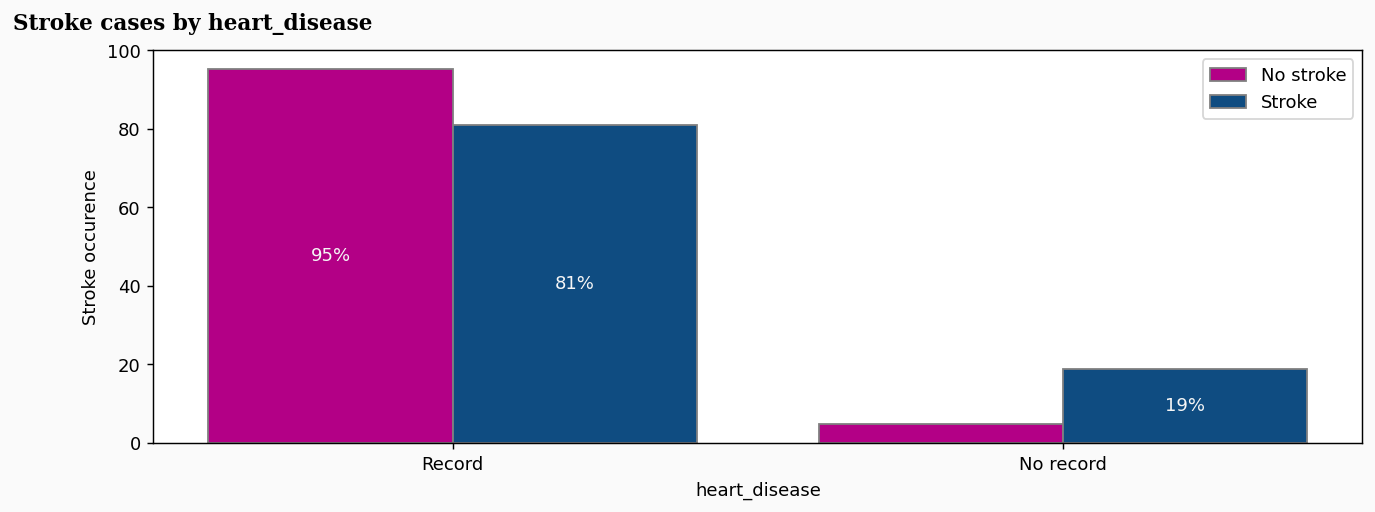

In [113]:
def category_by_stroke(data, category, ind=None):
    dataset_stroke_by = data[[category, "stroke"]]

    no_stroke = dataset_stroke_by[dataset_stroke_by["stroke"] == 0].groupby(category).count().reset_index()
    no_stroke["stroke"] = round(100*no_stroke["stroke"] / np.shape(dataset_stroke_by[dataset_stroke_by["stroke"] == 0])[0], 2)
    stroke = dataset_stroke_by[dataset_stroke_by["stroke"] == 1].groupby(category).count().reset_index()
    stroke["stroke"] = round(100*stroke["stroke"] / np.shape(dataset_stroke_by[dataset_stroke_by["stroke"] == 1])[0], 2)

    if ind is None:
        ind = no_stroke[category]
    X_axis = np.arange(len(ind))

    width = 0.40       # the width of the bars: can also be len(x) sequence
    fig = plt.figure(figsize=(12, 4),dpi=130, facecolor="#fafafa")

    ax = plt.subplot(111)
    color_nostroke = ["#b30086"]
    color_stroke = ["#0f4c81"]

    ax.bar(X_axis-0.2, no_stroke["stroke"], width,color=color_nostroke, align='center',edgecolor='grey')
    ax.bar(X_axis+0.2, stroke["stroke"], width, color=color_stroke, align='center',edgecolor='grey')

    plt.ylabel('Stroke occurence')
    plt.xlabel(category)

    fig.text(0.035,0.92,f'Stroke cases by {category}', fontfamily='serif', fontsize=12, fontweight='bold')

    plt.xticks(X_axis, ind)

    for i in range(np.shape(no_stroke)[0]):
        if no_stroke["stroke"][i] > 8:
            ax.annotate(f'{no_stroke["stroke"][i]:0.0f}%',xy=(i-0.2, no_stroke["stroke"][i]/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
        if stroke["stroke"][i] > 8:
            ax.annotate(f'{stroke["stroke"][i]:0.0f}%',xy=(i+0.2, stroke["stroke"][i]/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    plt.legend(["No stroke","Stroke"])
    plt.show()
    
# lets analyse hypertension on stroke
category_by_stroke(dataset, "heart_disease", ind=["Record", "No record"])


**Both record and no record categories are very similiar. No heart disesea record could mean a little bit higher risk of having a stroke. However if the patient has stroke, than it is highly likely that he or she has record of heart disease.**

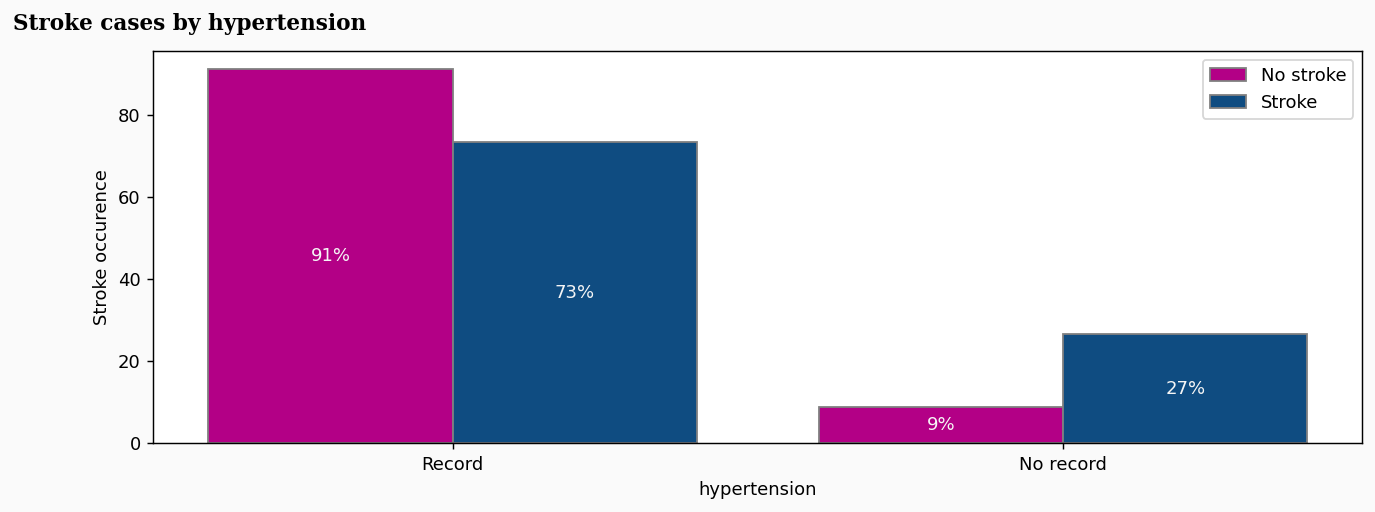

In [114]:
# lets analyse hypertension on stroke
category_by_stroke(dataset, "hypertension", ind=["Record", "No record"])

**Having no medical record of hypertension has a higher change of having a stroke, according to the plot. If the patient has stroke, than he or she has higher chance of having a record of hypertension as well.**

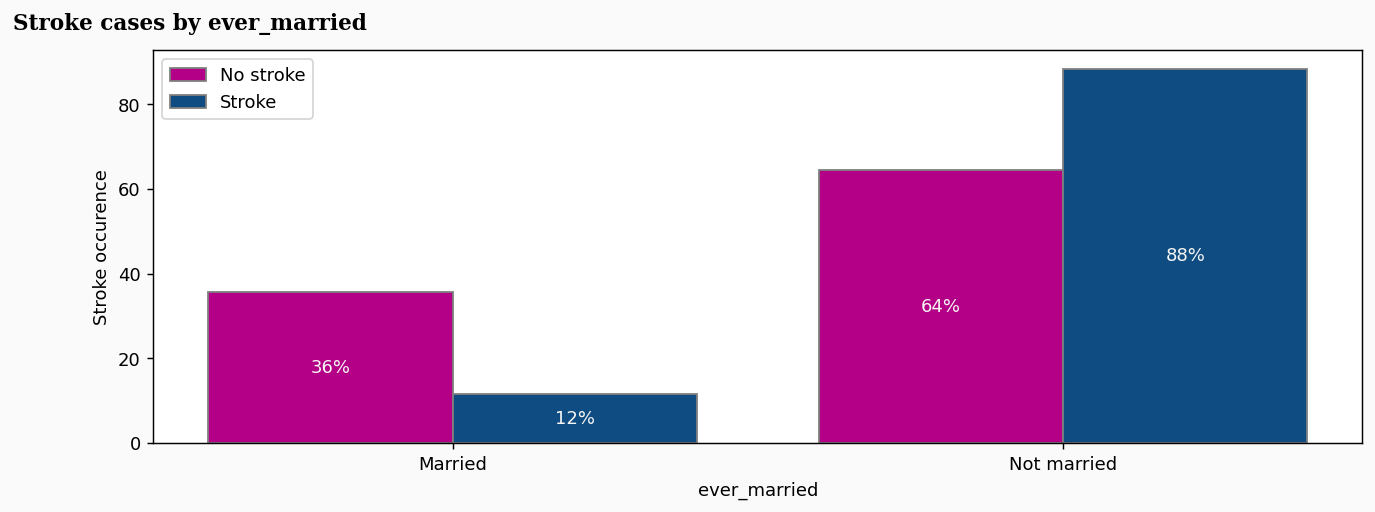

In [115]:
# marriage on stroke
category_by_stroke(dataset, "ever_married", ind=["Married", "Not married"])

**This variable has no direct causality with having a stroke from medical perspective, but it is interesting to investigate. This plot shows, that not married people are more affected by stroke, than those people who are married.**

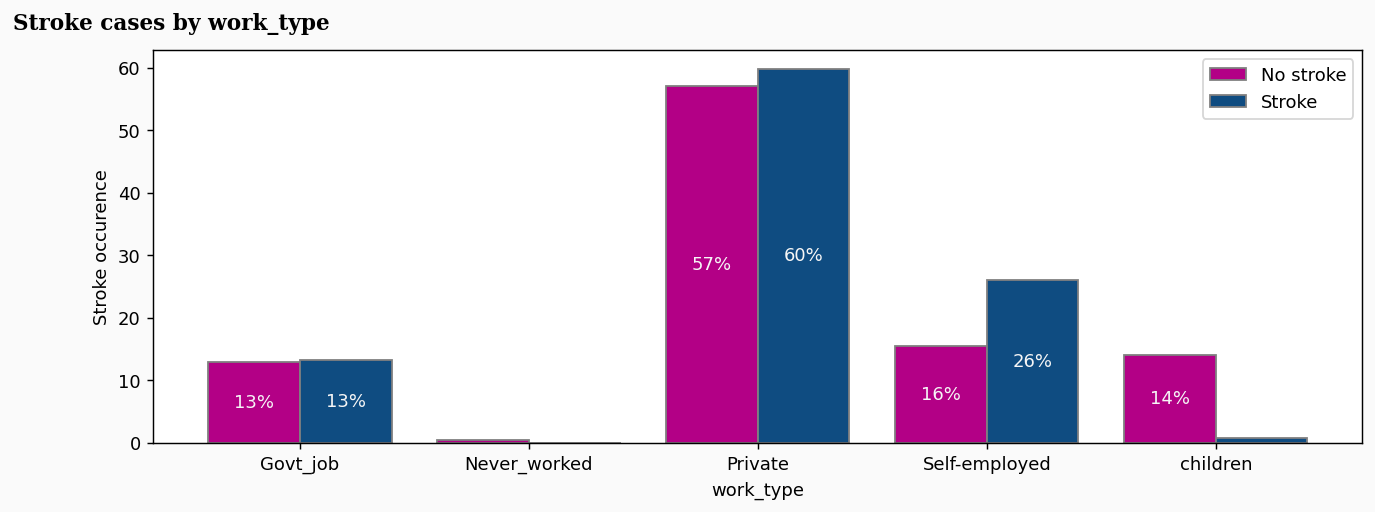

In [116]:
# work type on stroke
category_by_stroke(dataset, "work_type")

**Work type categories shows that self employed status is the one, which has worst chance of having a stroke or not. However people working in the private sector suffers the most of having a stroke out of all work types.**

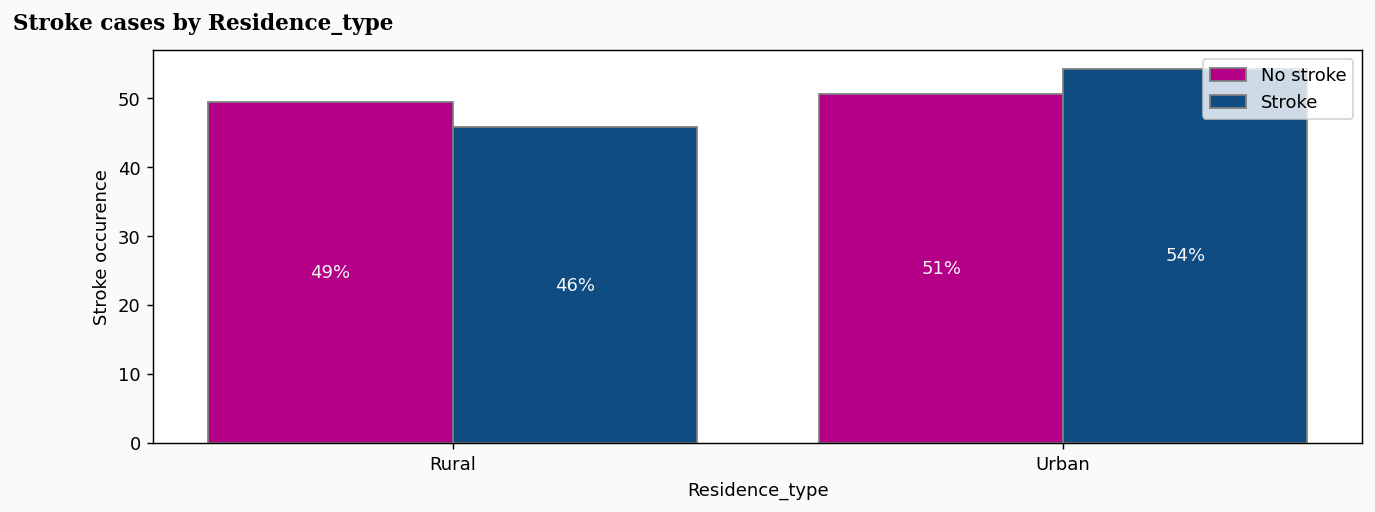

In [117]:
# residence type on stroke
category_by_stroke(dataset, "Residence_type")

**Residence shows similar distribution in both cases.**

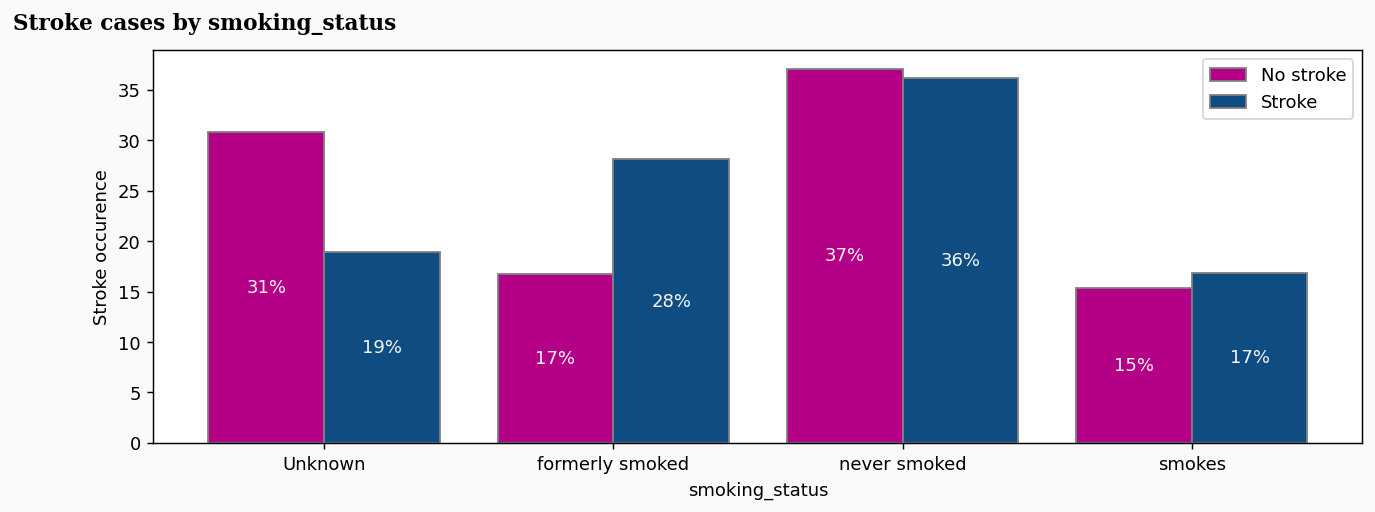

In [118]:
# smoking status on stroke
category_by_stroke(dataset, "smoking_status")

**Smoking status shows some controversial information. The carbon monoxide reduces the amount of oxygen in your blood, and the nicotine makes your heart beat faster and raises your blood pressure. This increases your risk of a stroke. Smoking can also trigger an episode of atrial fibrillation, a heart condition that is a risk factor for stroke. However, those people who never smoked, have the higher chance of getting a stroke according to the dataset. But formely smoked and smokes categories merged together, produces higher rate than never smoked category.**

C:\Users\zpap\Anaconda3\envs\ELTE\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


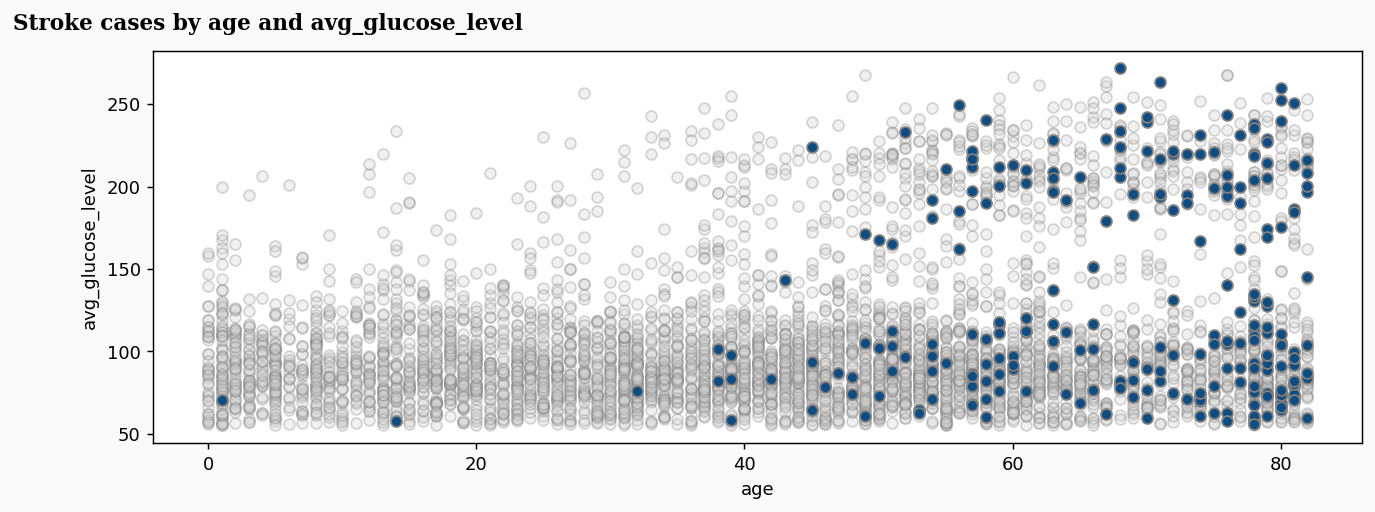

Text(0.035, 0.92, 'Stroke cases by age and bmi')

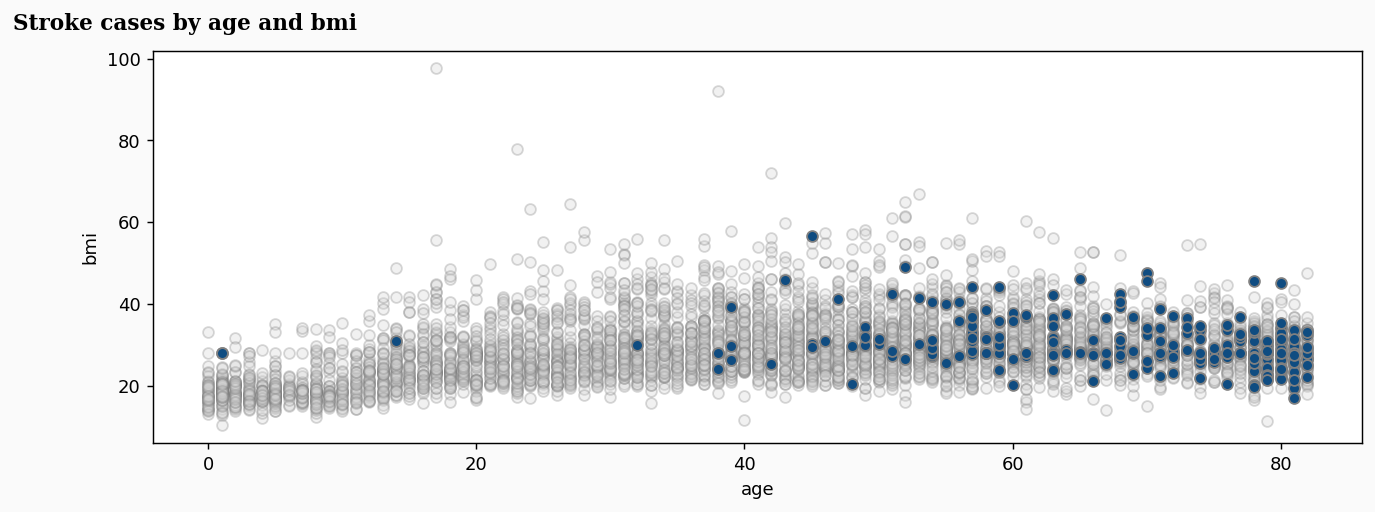

In [64]:
# lets check the glucose level
dataset_stroke_by_age_glucose = dataset[["age", "avg_glucose_level","bmi", "stroke"]]
dataset_stroke_by_age_glucose["age_cut"] = pd.cut(dataset_stroke_by_age["age"],
                                          bins=[-1, 6, 12, 18, 32, 45, 56, 60, 65, 70, 75, 80, 86],
                                          labels=["0-6", "6-12", "12-18", "18-32", "32-45",
                                                  "45-56", "56-60", "60-65","65-70", "70-75", "75-80", "80-86"])

stroke_by_age_glucose = dataset_stroke_by_age_glucose[dataset_stroke_by_age_glucose["stroke"] == 1]
nonstroke_by_age_glucose = dataset_stroke_by_age_glucose[dataset_stroke_by_age_glucose["stroke"] == 0]

fig = plt.figure(figsize=(12, 4), dpi=130, facecolor="#fafafa")

ax = plt.subplot(111)
ax.scatter(y=nonstroke_by_age_glucose["avg_glucose_level"], x=nonstroke_by_age_glucose["age"], c="lightgrey", alpha=0.3,edgecolors="grey")
ax.scatter(y=stroke_by_age_glucose["avg_glucose_level"], x=stroke_by_age_glucose["age"], c="#0f4c81",edgecolors="grey")

plt.ylabel('avg_glucose_level')
plt.xlabel("age")

fig.text(0.035, 0.92, f'Stroke cases by age and avg_glucose_level', fontfamily='serif', fontsize=12, fontweight='bold')
plt.show()
plt.close()


fig = plt.figure(figsize=(12, 4), dpi=130, facecolor="#fafafa")

ax = plt.subplot(111)
ax.scatter(y=nonstroke_by_age_glucose["bmi"], x=nonstroke_by_age_glucose["age"], c="lightgrey", alpha=0.3,edgecolors="grey")
ax.scatter(y=stroke_by_age_glucose["bmi"], x=stroke_by_age_glucose["age"], c="#0f4c81",edgecolors="grey")

plt.ylabel('bmi')
plt.xlabel("age")

fig.text(0.035, 0.92, f'Stroke cases by age and bmi', fontfamily='serif', fontsize=12, fontweight='bold')

**Average glucose level by age shows that as people getting older, their glucose level rises up. This process does not affect everyone, but those people, who have suffered stroke definitely.**<br><br>
**BMI index has a stable variance through all ages.**

C:\Users\zpap\Anaconda3\envs\ELTE\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


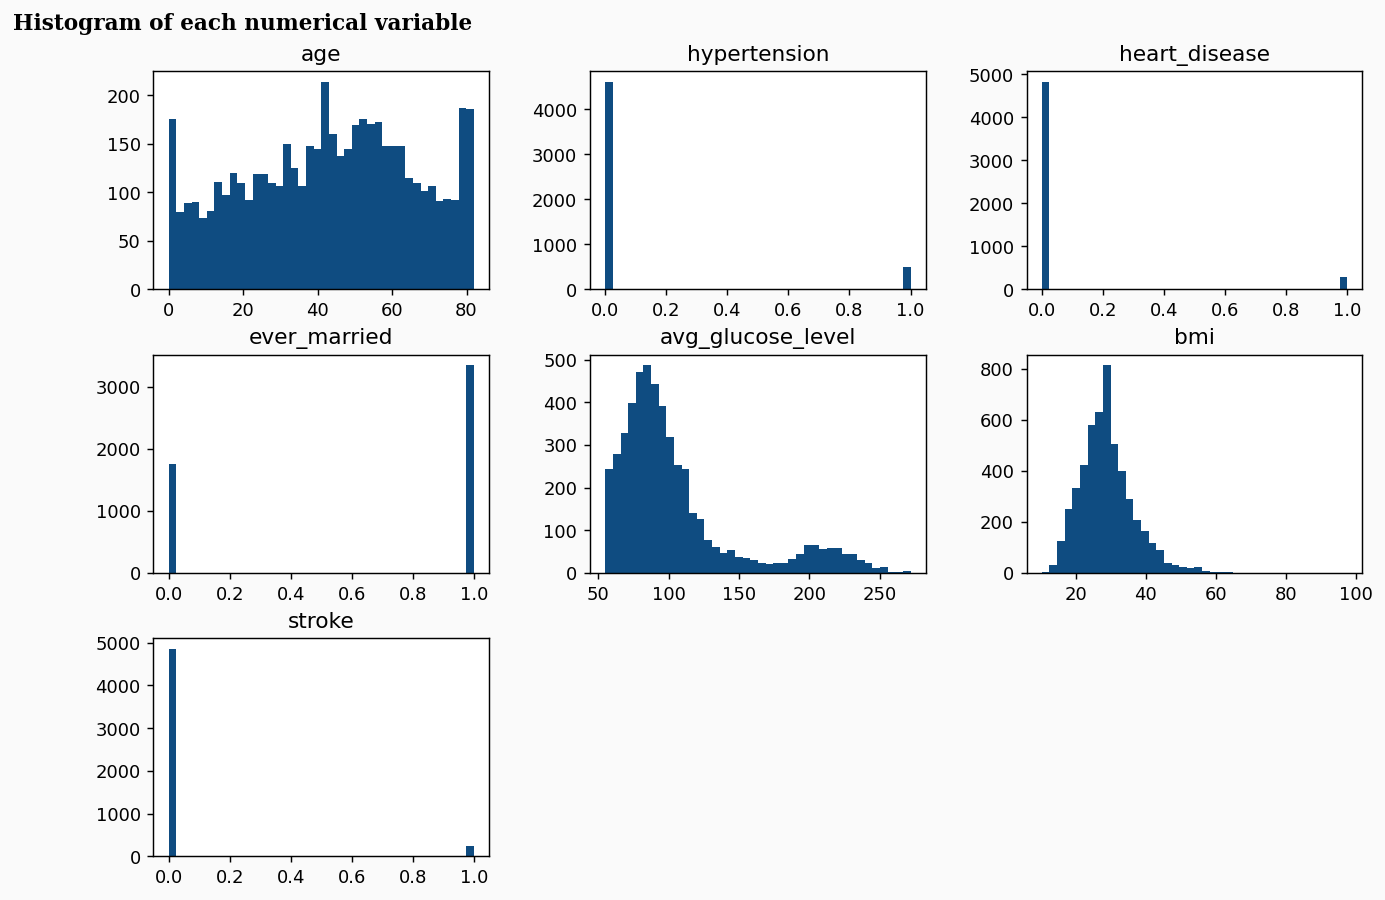

In [52]:
# histogram of numerical variables
fig, ax = plt.subplots(figsize=(12, 8), dpi=130, facecolor="#fafafa")
dataset.hist(bins=40, ax=ax, color="#0f4c81", grid=False)
fig.text(0.035, 0.92, f'Histogram of each numerical variable', fontfamily='serif', fontsize=12, fontweight='bold')

plt.show()


**Hypertension and heart disease occurs rarely in the dataset. The majority of people are married, but this plot does include childre, so it is a little bit distorted. Average glucose shows that there are a few people with really high glucose level and there is a little gap around 175. BMI index has a normal ditribution.**

In [187]:
# describe data
descriptive_stat = dataset.describe(include="all").round(2)
s = descriptive_stat.style.format(na_rep='Na', precision=2)
cell_hover = { 
    'selector': 'td:hover',
    'props': [('background-color', 'lightblue'), ('font-style', 'serif')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: serif; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #0f4c81; color: white;font-style: serif;'
}
s.set_table_styles([cell_hover, index_names, headers])


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.00,5110.00,5110.00,5110,5110,5110,5110.00,5110.00,5110,5110.00
unique,3,Na,Na,Na,2,5,2,Na,Na,4,Na
top,Female,Na,Na,Na,Yes,Private,Urban,Na,Na,never smoked,Na
freq,2994,Na,Na,Na,3353,2925,2596,Na,Na,1892,Na
mean,Na,43.22,0.10,0.05,Na,Na,Na,106.15,28.86,Na,0.05
std,Na,22.63,0.30,0.23,Na,Na,Na,45.28,7.70,Na,0.22
min,Na,0.00,0.00,0.00,Na,Na,Na,55.12,10.30,Na,0.00
25%,Na,25.00,0.00,0.00,Na,Na,Na,77.24,23.80,Na,0.00
50%,Na,45.00,0.00,0.00,Na,Na,Na,91.88,28.10,Na,0.00
75%,Na,61.00,0.00,0.00,Na,Na,Na,114.09,32.80,Na,0.00


In [186]:
average_distribution = dataset.groupby("stroke")[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']].mean()
s = average_distribution.style.format(na_rep='Na', precision=2)
cell_hover = { 
    'selector': 'td:hover',
    'props': [('background-color', 'lightblue'), ('font-style', 'serif')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: serif; color: white; background-color: #0f4c81; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #0f4c81; color: white;font-style: serif;'
}
s.set_table_styles([cell_hover, index_names, headers])

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.96,0.09,0.05,104.80,28.80
1,67.73,0.27,0.19,132.54,30.09


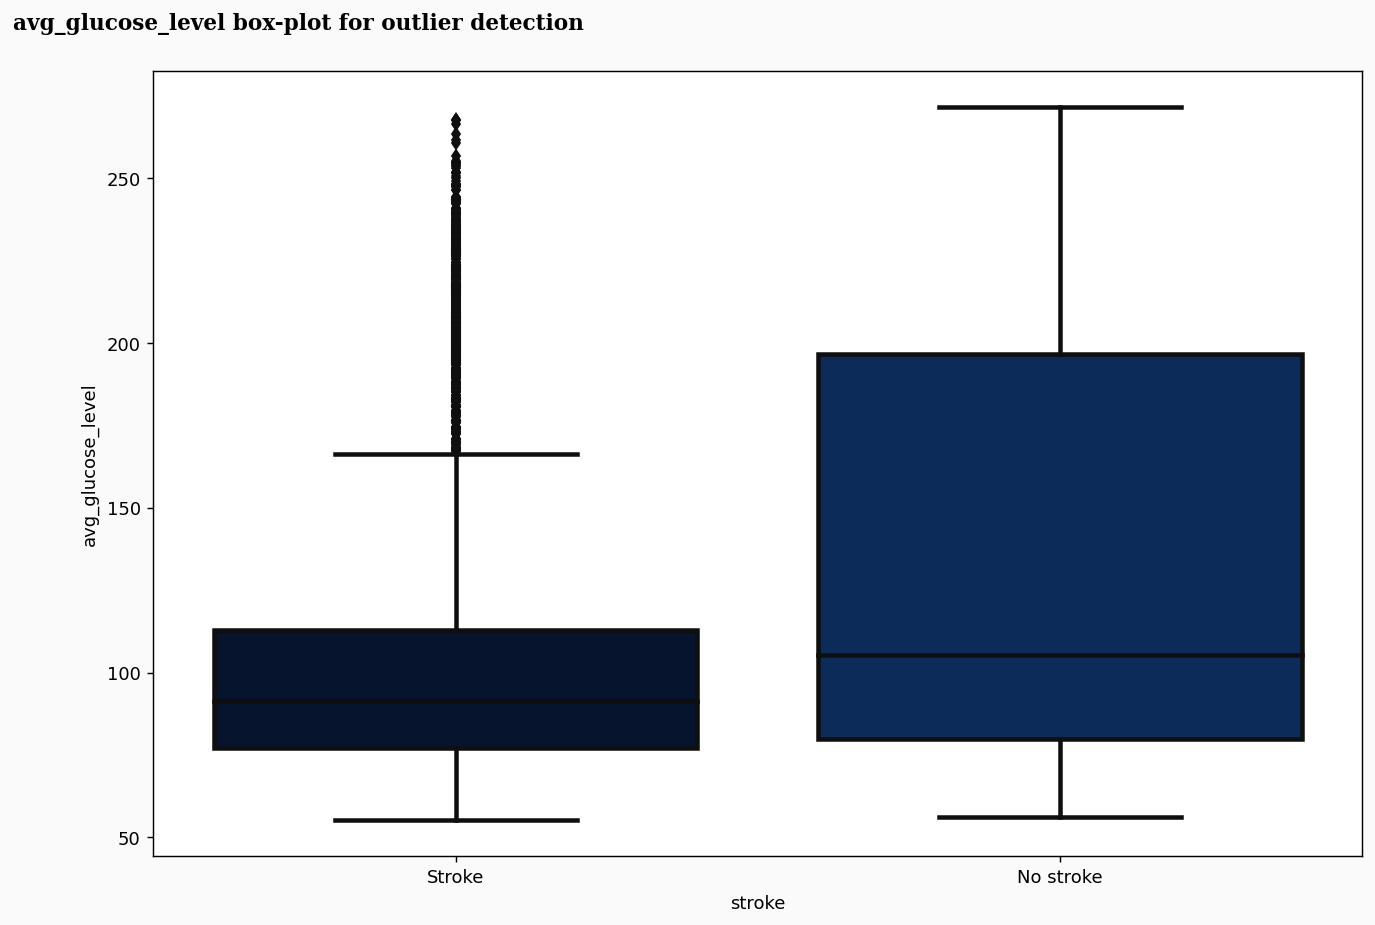

In [188]:
# outlier detection for continous variables
fig, ax = plt.subplots(figsize=(12, 8), dpi=130, facecolor="#fafafa")
sb.boxplot(x="stroke", y="avg_glucose_level", data=dataset,linewidth=2.5, palette=colors)
ax.set_xticklabels(["Stroke", "No stroke"])
fig.text(0.035, 0.92, f'{"avg_glucose_level"} box-plot for outlier detection', fontfamily='serif', fontsize=12, fontweight='bold')
plt.show()

**There are outliers in this variable, as it can be seen in case of stroke. Maximum values are way further than the third quartile. It must be handled during the feature engineering phase.**

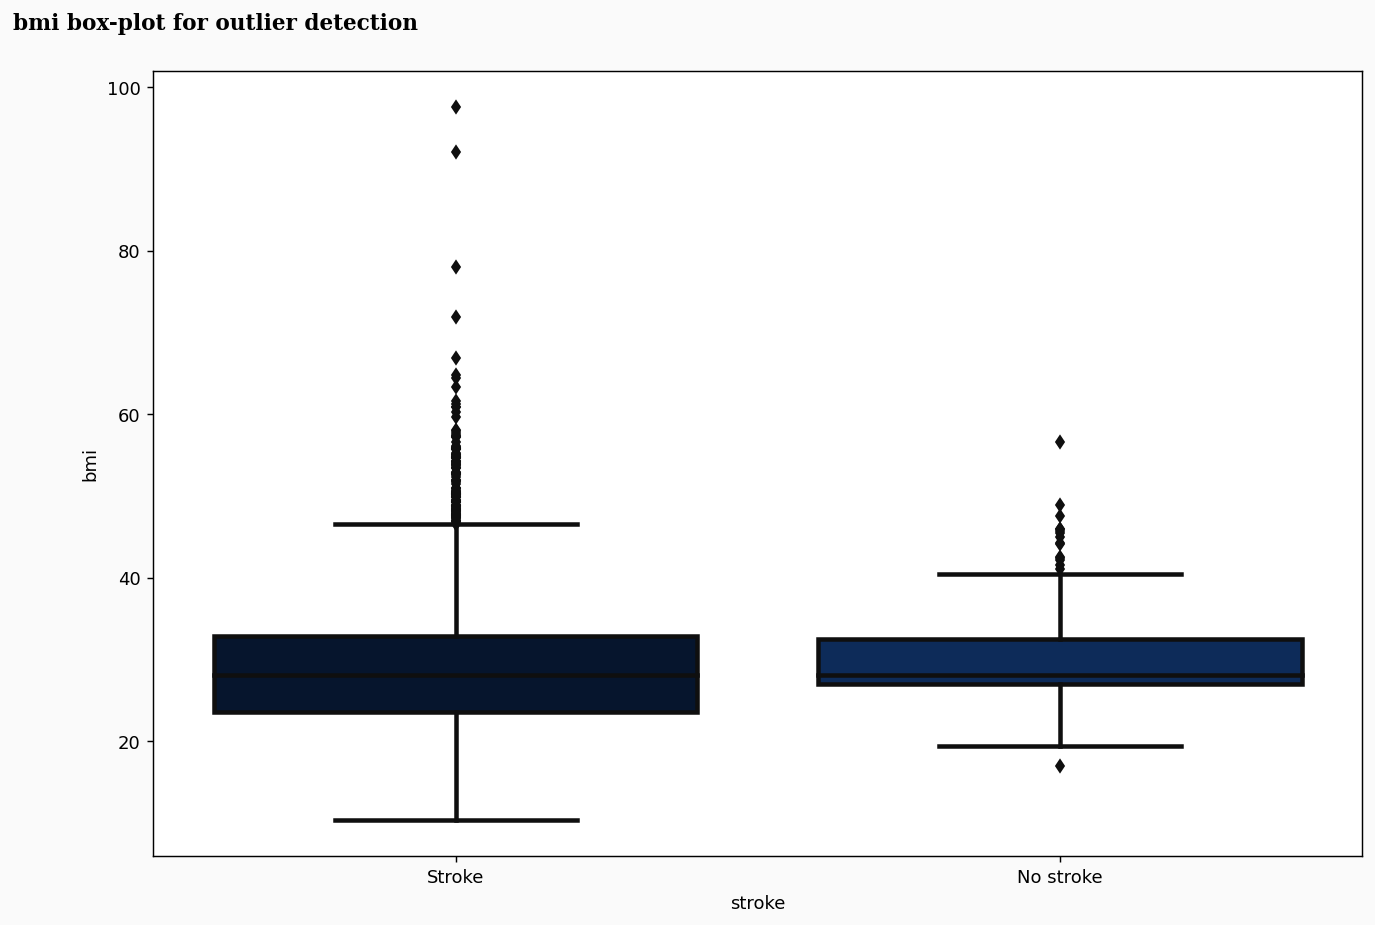

In [189]:
# outlier detection for continous variables
fig, ax = plt.subplots(figsize=(12, 8), dpi=130, facecolor="#fafafa")
sb.boxplot(x="stroke", y="bmi", data=dataset,linewidth=2.5, palette=colors)
ax.set_xticklabels(["Stroke", "No stroke"])
fig.text(0.035, 0.92, f'{"bmi"} box-plot for outlier detection', fontfamily='serif', fontsize=12, fontweight='bold')
plt.show()

**BMI has also outliers in both cases. Maximum values are way further than the third quartile. It must be handled during the feature engineering phase.**

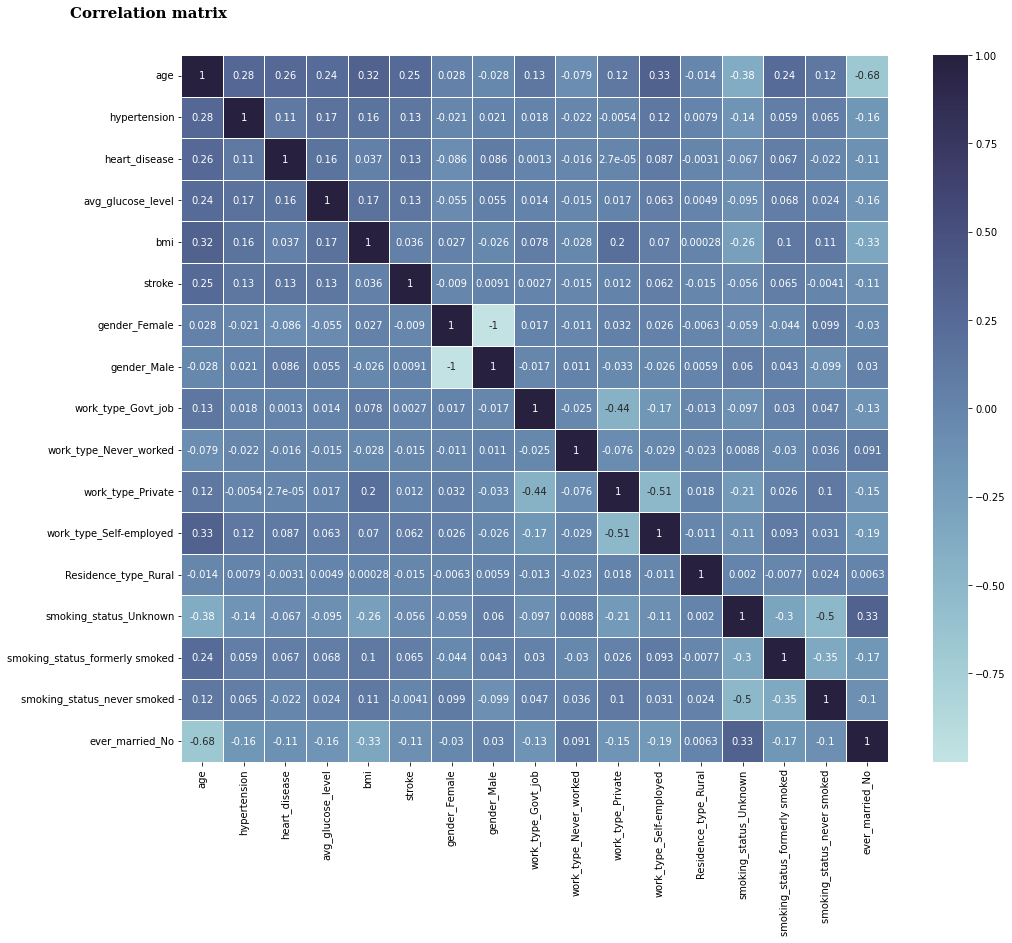

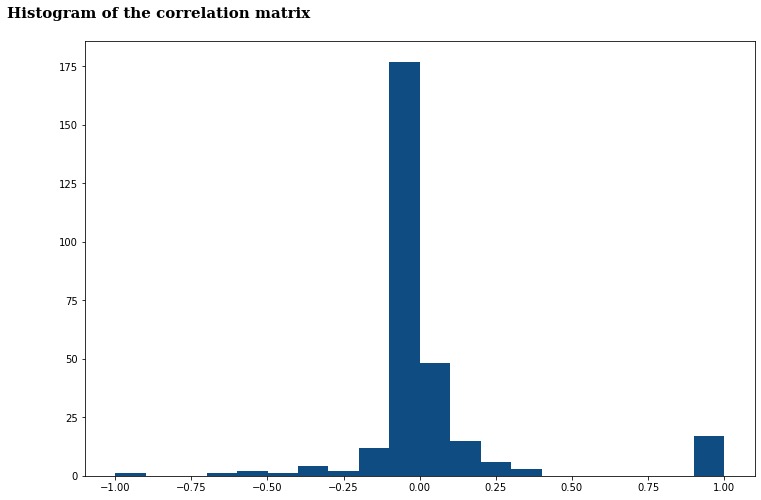

In [190]:
# Compute the correlation matrix, where category variables transformed to dummies.
dataset = create_dummies(dataset.copy(), "gender")
dataset = create_dummies(dataset, "work_type")
dataset = create_dummies(dataset, "Residence_type")
dataset = create_dummies(dataset, "smoking_status")
dataset = create_dummies(dataset, "ever_married")

corr = dataset.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 13))

# Generate a custom diverging colormap
cmap = sb.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5,annot=True)


f.text(0.035, 0.92, f'Correlation matrix', fontfamily='serif', fontsize=15, fontweight='bold')



corr = np.tril(data_cleaned.corr()).ravel()
f, ax = plt.subplots(figsize=(12, 8))
f.text(0.035, 0.92, f'Histogram of the correlation matrix', fontfamily='serif', fontsize=15, fontweight='bold')
plt.hist(corr, bins=20, color="#0f4c81")
plt.show()

**Histogram shows the frequency of correlation coefficients among all feature pairs. It shows that the majority of features is only weakly correlated.** <br><br>
**However correlation can be observed in a few cases:**
* Gender Female and Gender Male dummies, are inverse of each other, and there is only 1 row, where data has a record of "Other gender", which was left out from the dataset. Since we dont want to add duplicated information in our modelset, one of the dummy variable of gender will be removed.
* Worky type dummmies suffer from moderate correlation, just like smoking status.
* Age and evermarried have negative correlation, in case of No dummy, which is plausible.

---------- Model: RandomForestClassifier()
---- Applied scoring method: recall_weighted  (std deviation)
>1 0.086 (0.009)
>2 0.057 (0.010)
>3 0.053 (0.010)
>4 0.052 (0.011)
>5 0.052 (0.011)
>6 0.052 (0.010)
   Performance       lag   diff
0     0.085975       NaN    NaN
1     0.057143  0.085975  0.029
2     0.053033  0.057143  0.004
3     0.052446  0.053033  0.001
4     0.052055  0.052446  0.000
5     0.051794  0.052055  0.000
[0, 0, 1, 0, 0, 0]


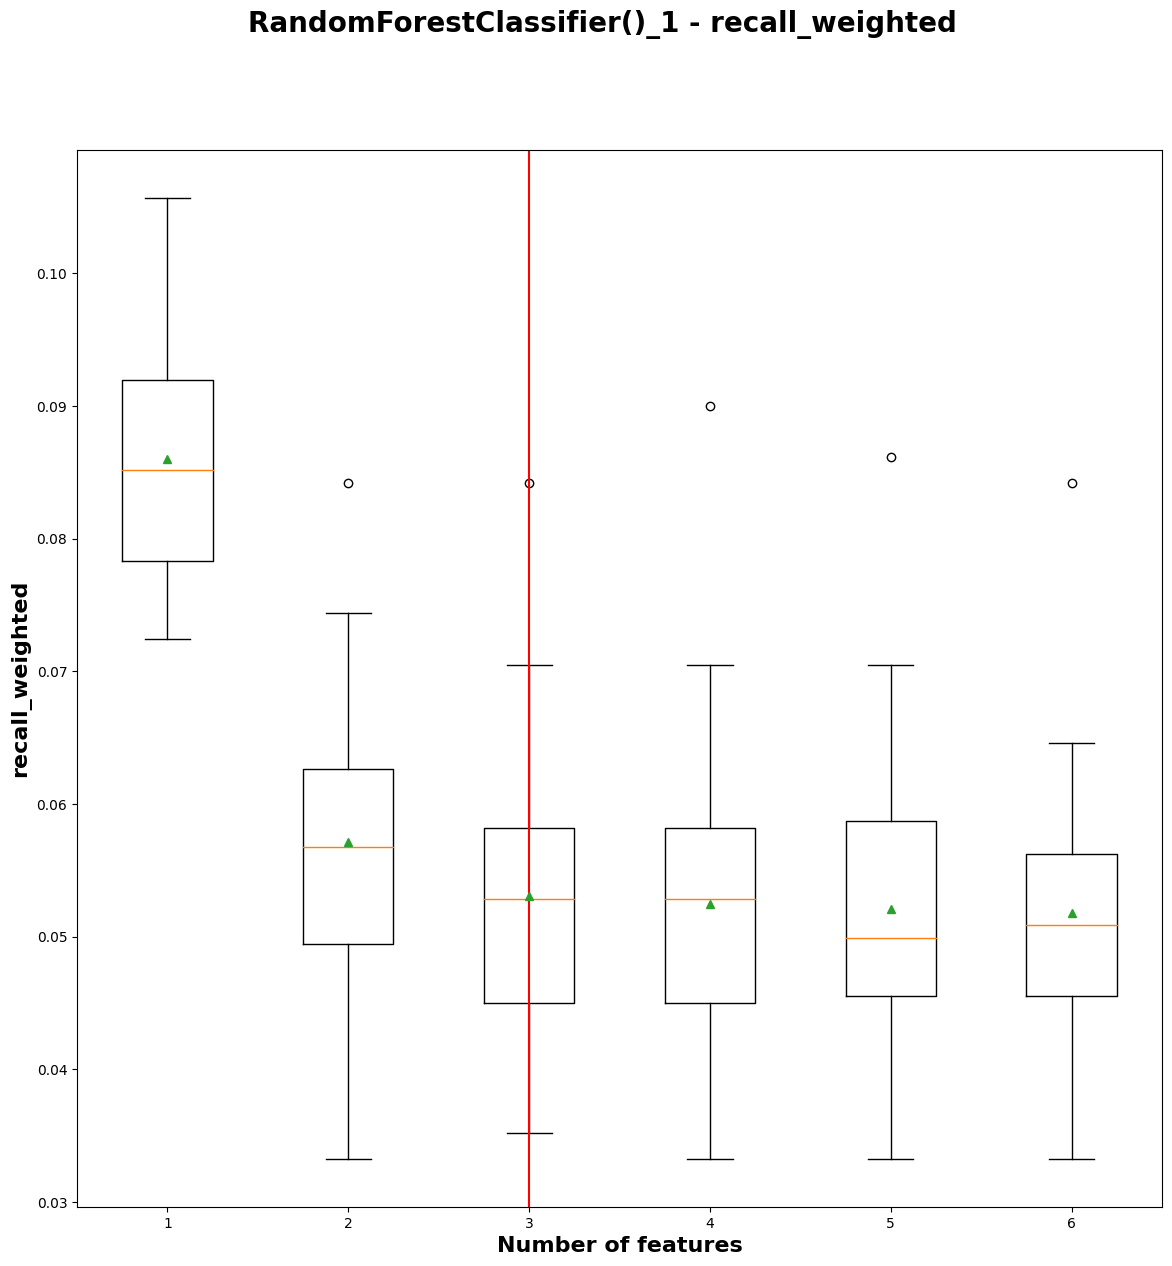

,RandomForestClassifier()
0,age
1,avg_glucose_level
2,bmi


In [221]:
def get_models(estimator, num_features_tested):
    models = dict()
    for i in range(1, num_features_tested+1):
        rfe = RFE(estimator=estimator, n_features_to_select=i)
        model = estimator
        models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models


# evaluate a give model using cross-validation
def evaluate_model(model, X, y, scoring):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = 1 - cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=20, error_score='raise')
    return scores


def recursive_feature_elimination(data, estimators, num_features_tested, scoring, optimum):


    y = data["stroke"]
    X = data.drop("stroke", axis=1)

    # get the models to evaluate
    for model_i in estimators:
        var_selected_by_pos_model = {}

        print("---------- Model: " + str(model_i))
        models = get_models(model_i, num_features_tested=num_features_tested)



        for scoring_i in scoring:
            print("---- Applied scoring method: " + str(scoring_i) + " " + " (std deviation)")

            # evaluate the models and store results
            score_list, results, names = list(), list(), list()

            for name, model in models.items():
                scores = evaluate_model(model, X, y, scoring=scoring_i)
                results.append(scores)
                names.append(name)
                print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
                score_list.append(mean(scores))

            feature_perf = pd.DataFrame({"Performance": score_list})
            feature_perf["lag"] = feature_perf.Performance.shift(1)
            feature_perf["diff"] = round(feature_perf.lag - feature_perf.Performance, 3)
            
            print(feature_perf)
            
            feature_perf.iloc[0,:] = [0,0,1]
            num_features_where_diff_1_percent = list(np.where((optimum[0] < abs(feature_perf["diff"])) & (optimum[1] > abs(feature_perf["diff"])), 1, 0))

            
            print(num_features_where_diff_1_percent)
            n_features_to_select = next(x for x in
                                                range(len(num_features_where_diff_1_percent)) if
                                                num_features_where_diff_1_percent[x] == 1)+1


            # plot model performance for comparison
            fig = plt.figure(figsize=(14, 14), dpi=100)
            fig.suptitle(str(model_i) + "_" + "1 - " + str(scoring_i), fontsize=20, fontweight='bold')

            ax = fig.add_subplot(111)
            ax.boxplot(results, labels=names, showmeans=True)
            plt.axvline(x=n_features_to_select, c="r")
            ax.set_xlabel('Number of features', fontsize=16, fontweight='bold')
            ax.set_ylabel(scoring_i, fontsize=16, fontweight='bold')


            rfe = RFE(estimator=model_i, n_features_to_select=n_features_to_select)
            # fit RFE
            rfe.fit(X, y)
            # summarize all features
            final_vars = []
            for i in range(X.shape[1]):
                if rfe.support_[i] == True:
                    final_vars.append(data.columns[1:][i])
            var_selected_by_pos_model[str(model_i)] = final_vars

            plt.show()

            return(pd.DataFrame(var_selected_by_pos_model))


cols = dataset.columns.tolist()
cols.remove("stroke")
cols.insert(0,"stroke")
dataset = dataset[cols]

result = recursive_feature_elimination(data=dataset,
                                       estimators=[RandomForestClassifier()],
                                       num_features_tested=6,
                                       scoring=["recall_weighted"],
                                       optimum=[0.001, 0.007])

s = result.style.format(na_rep='Na', precision=2)
cell_hover = { 
                'selector': 'td:hover',
                'props': [('background-color', 'lightblue'), ('font-style', 'serif')]
}
index_names = {
                'selector': '.index_name',
                'props': 'font-style: serif; color: white; background-color: #0f4c81; font-weight:normal;'
}
headers = {
                'selector': 'th:not(.index_name)',
                 'props': 'background-color: #0f4c81; color: white;font-style: serif;'
}
s.set_table_styles([cell_hover, index_names, headers])

In [ ]:
rf = RandomForestClassifier()
rf.fit(dataset.drop("stroke", axis=1), dataset.stroke)
importances = rf.feature_importances_
features = pd.Series(importances, index=dataset.drop("stroke", axis=1).columns).sort_values()

fig, ax = plt.subplots(figsize=(12, 8), dpi=130, facecolor="#fafafa")
ax.barh(width=features, y=features.index, color=colors[1])
fig.text(0.035, 0.92, f'Feature importance', fontfamily='serif', fontsize=12, fontweight='bold')

plt.show()

**Feature importance shows that 3 variables have really high potential effect among all predictors to explain stroke:**
* avg_glucose_level
* age
* bmi
* Residence_type

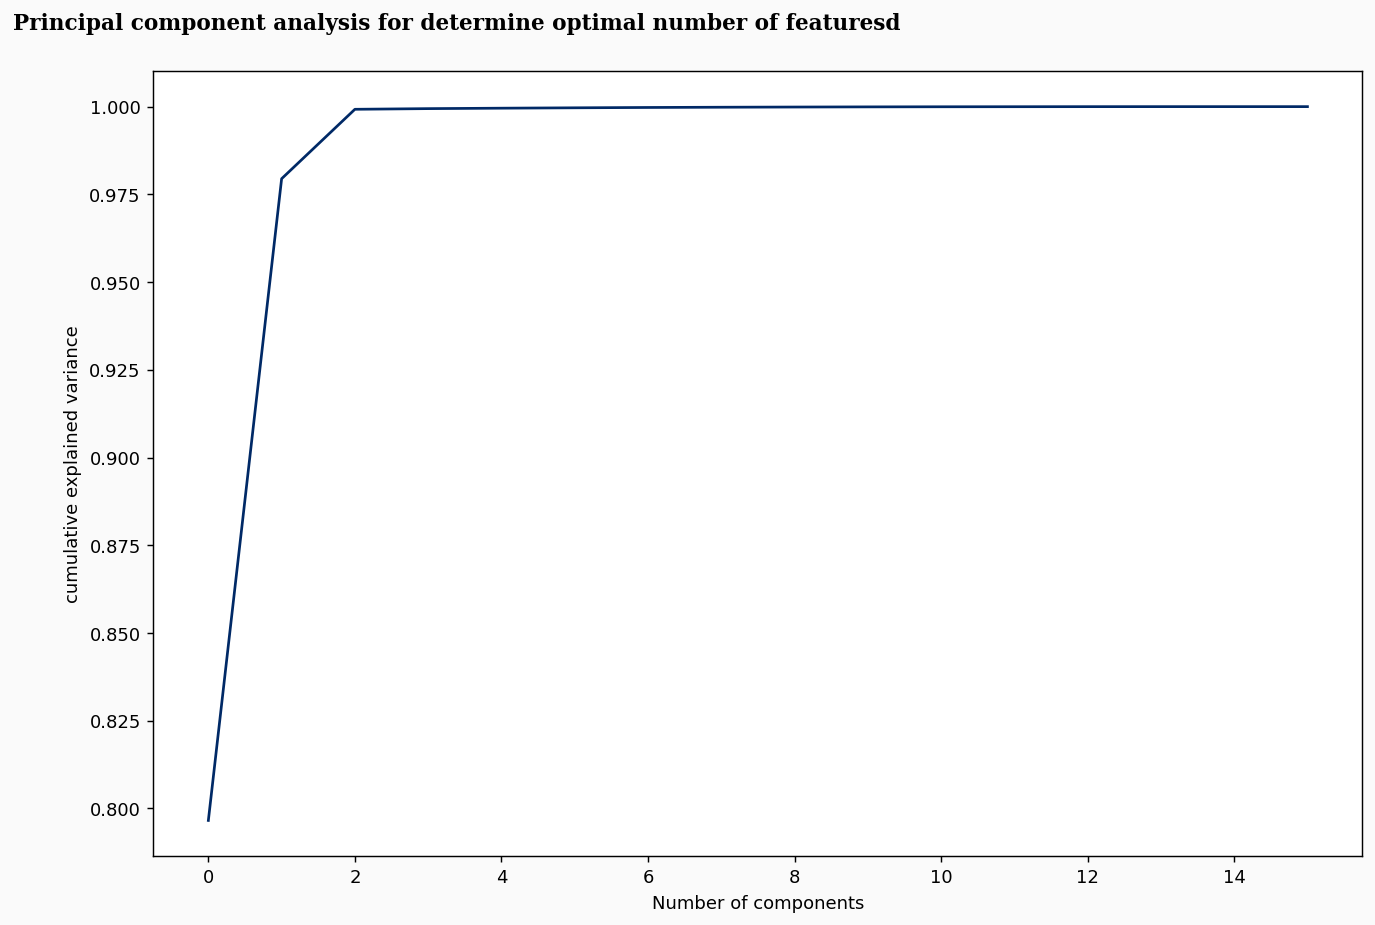

In [201]:
pca = PCA().fit(dataset.drop("stroke", axis=1))
fig, ax = plt.subplots(figsize=(12, 8), dpi=130, facecolor="#fafafa")

plt.plot(np.cumsum(pca.explained_variance_ratio_),color=colors[1])
fig.text(0.035, 0.92, f'Principal component analysis for determine optimal number of featuresd', fontfamily='serif', fontsize=12, fontweight='bold')

ax.set_xlabel('Number of components')
ax.set_ylabel('cumulative explained variance');

**This unsupervised technique shows, that only 2 component is enough to explain most of the variance in the dataset, which is in connection with the feature_importance result.